In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_btsp_input_distribution(network, patterns, trained_indices, neuron_idx=0, bins=50):

    ##绘制单个CA1神经元对所有模式的输入加和分布

    patterns = patterns.to(network.device).float()
    
    weights = network.synaptic_strengths[neuron_idx]  
    input_sums = (patterns @ weights).detach().cpu().numpy()

    # 划分已训练和未训练模式
    trained_mask = np.zeros(len(patterns), dtype=bool)
    trained_mask[trained_indices] = True

    trained_inputs = input_sums[trained_mask]  
    untrained_inputs = input_sums[~trained_mask] 

    
    plt.figure(figsize=(8,5))
    plt.hist(untrained_inputs, bins=bins, color="green", alpha=0.6, label="未训练")
    plt.hist(trained_inputs, bins=bins, color="yellow", alpha=0.6, label="训练过")
    plt.axvline(network.threshold[neuron_idx].item(), color="red", linestyle="--", label="阈值")


    plt.xlabel("突触输入总和")
    plt.ylabel("记忆数量")
    plt.title(f"CA1神经元 {neuron_idx} 的输入加和分布")
    plt.legend()
    plt.show()

    return trained_inputs, untrained_inputs

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from binary_btsp_network_torch import BinaryBTSPNetworkTorch
import os
from tqdm import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"




n_input = 10000   # CA3
n_memory = 15000  # CA1 
n_patterns = 13000 
fq = 0.0025           # 更新概率
fp = 0.005        # 输入稀疏度
fw = 0.6           # 连接稀疏度


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")


net = BinaryBTSPNetworkTorch(
    n_input=n_input,
    n_memory=n_memory,
    fq=fq,
    fp=fp,
    fw=fw,
    device=device,
    threshold=8
)



patterns = net.make_sparse_patterns(n_patterns)


neuron_idx = 10  
neuron_trained_pattern_indices = []  

#  对所有模式训练（逐条）并检测 neuron 的可塑性 
for i in tqdm(range(n_patterns), desc="Training patterns"):
    x = patterns[i].to(device)  
    active_idx = torch.nonzero(x, as_tuple=True)[0]
    if active_idx.numel() == 0:
        continue

    # 当前活跃连接：shape = (n_memory, n_active)
    active_connections = net.connections[:, active_idx].bool()
    has_active_connection = active_connections.any(dim=1)

    # 对每个 CA1 神经元，以 fq 概率决定是否更新（前提是它与活跃 CA3 相连）
    rand_neuron_update = torch.rand(net.n_memory, device=device)
    neuron_update_mask = (rand_neuron_update < net.fq) & has_active_connection  # bool

    # 检查目标 neuron 是否被选中更新
    if neuron_update_mask[neuron_idx]:
        neuron_trained_pattern_indices.append(i)

    # 对被选中更新的神经元，执行突触翻转
    if neuron_update_mask.any():
        neuron_indices = torch.nonzero(neuron_update_mask, as_tuple=True)[0]
        for neuron_j in neuron_indices:
            connected_active = active_connections[neuron_j]  # bool over active_idx
            if not connected_active.any():
                continue
            input_indices = active_idx[connected_active]
            flip_mask = (torch.rand_like(input_indices.float()) < 0.5)
            if flip_mask.any():
                flip_indices = input_indices[flip_mask]
                cur = net.synaptic_strengths[neuron_j, flip_indices]
                new = 1.0 - cur
                net.synaptic_strengths[neuron_j, flip_indices] = new

# 输出统计 
neuron_trained_pattern_indices = np.array(neuron_trained_pattern_indices, dtype=np.int64)
print(f"监控神经元 {neuron_idx} 在训练过程中发生可塑性的模式数: "
      f"{len(neuron_trained_pattern_indices)} / {n_patterns}")



使用设备: cuda


Training patterns: 100%|██████████| 13000/13000 [04:11<00:00, 51.62it/s]

监控神经元 10 在训练过程中发生可塑性的模式数: 37 / 13000


NameError: name 'plot_btsp_input_distribution' is not defined

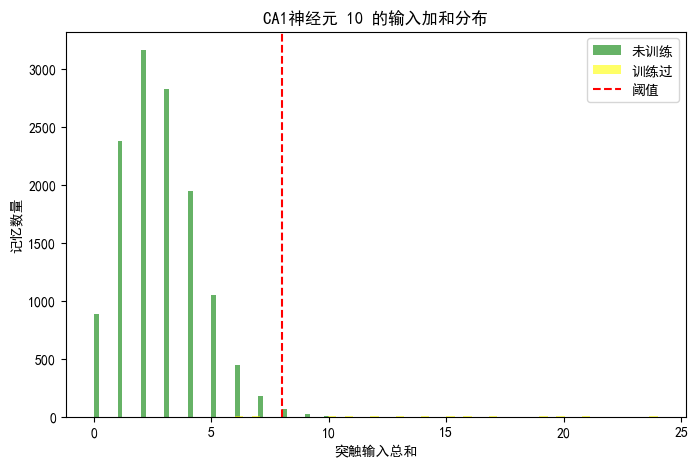

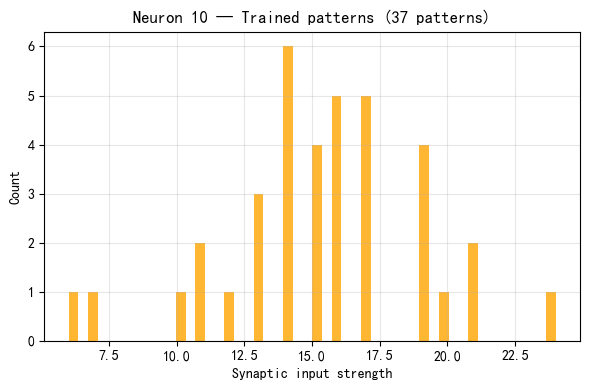

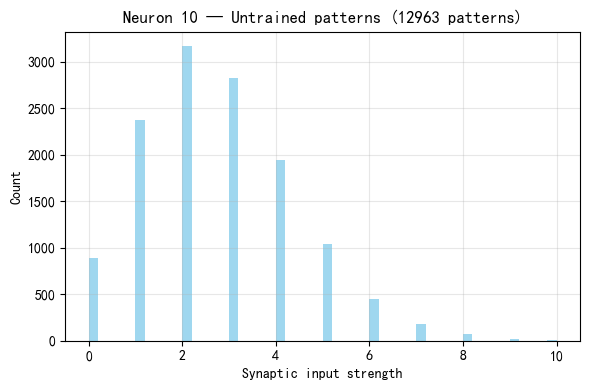

In [ ]:

trained_inputs, untrained_inputs = plot_btsp_input_distribution(
    net, patterns, neuron_trained_pattern_indices, neuron_idx=neuron_idx
)

plt.figure(figsize=(6, 4))
plt.hist(trained_inputs.ravel(), bins=50, color='orange', alpha=0.8)
plt.xlabel("Synaptic input strength")
plt.ylabel("Count")
plt.title(f"Neuron {neuron_idx} — Trained patterns ({len(neuron_trained_pattern_indices)} patterns)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

untrained_indices = np.setdiff1d(np.arange(n_patterns), neuron_trained_pattern_indices)
plt.figure(figsize=(6, 4))
plt.hist(untrained_inputs.ravel(), bins=50, color='skyblue', alpha=0.8)
plt.xlabel("Synaptic input strength")
plt.ylabel("Count")
plt.title(f"Neuron {neuron_idx} — Untrained patterns ({len(untrained_indices)} patterns)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



使用设备: cuda


Training patterns: 100%|██████████| 14000/14000 [00:08<00:00, 1748.53it/s]


监控神经元 10 在训练过程中发生可塑性的模式数: 30 / 14000


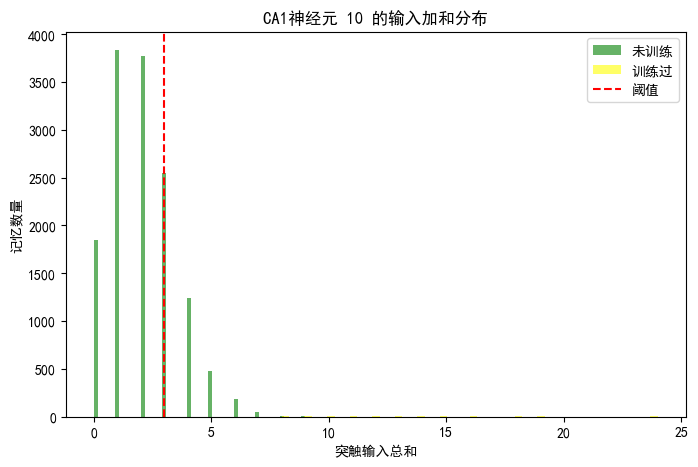

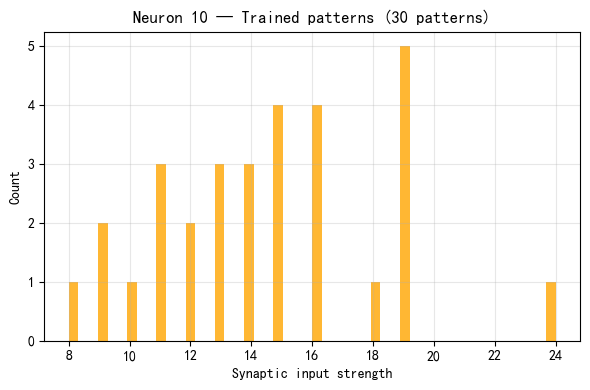

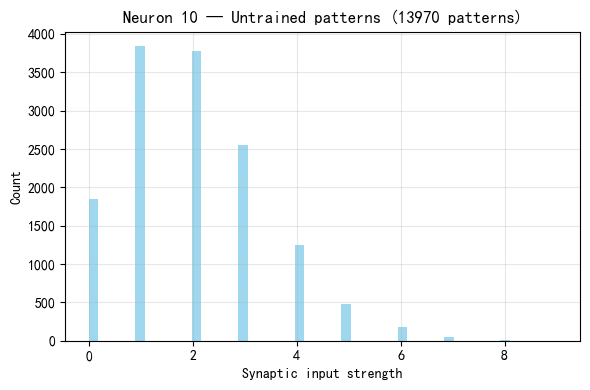

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from binary_btsp_network_torch import BinaryBTSPNetworkTorch
from tqdm import tqdm
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# ---------------- 参数设置 ----------------
n_input = 10000    # CA3 神经元数
n_memory = 15000   # CA1 神经元数
n_patterns = 14000 # 总记忆模式数量
fq = 0.0025        # BTSP 更新概率（CA1 neuron 整体翻转概率）
fp = 0.005         # 输入稀疏度
fw = 0.6           # 连接稀疏度

# ---------------- 设备选择 ----------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

# ---------------- 初始化网络 ----------------
net = BinaryBTSPNetworkTorch(
    n_input=n_input,
    n_memory=n_memory,
    fq=fq,
    fp=fp,
    fw=fw,
    device=device,
    threshold=3
)

# ---------------- 生成稀疏输入模式 ----------------
patterns = net.make_sparse_patterns(n_patterns).to(device)  # 一次性放到 GPU

# ---------------- 监控 neuron ----------------
neuron_idx = 10  # 要分析的 CA1 神经元
neuron_trained_pattern_indices = []

# ---------- 向量化训练循环 ----------
for i in tqdm(range(n_patterns), desc="Training patterns"):
    x = patterns[i]                 # shape: (n_input,)
    active_idx = torch.nonzero(x, as_tuple=True)[0]
    if active_idx.numel() == 0:
        continue

    # 1. 当前 pattern 下的活跃连接
    active_connections = net.connections[:, active_idx].bool()  # shape: (n_memory, n_active)
    has_active_connection = active_connections.any(dim=1)      # shape: (n_memory,)

    # 2. CA1 neuron 更新 mask（fq 概率决定 neuron 是否更新）
    rand_neuron_update = torch.rand(net.n_memory, device=device)
    neuron_update_mask = (rand_neuron_update < net.fq) & has_active_connection  # bool tensor

    # 3. 检测指定 neuron 是否被选中
    if neuron_update_mask[neuron_idx]:
        neuron_trained_pattern_indices.append(i)

    if neuron_update_mask.any():
        # 4. 扩展 neuron 更新 mask 到所有活跃输入
        neuron_update_mask_expanded = neuron_update_mask[:, None].expand(-1, active_idx.numel())

        # 5. 生成 50% 翻转 mask
        flip_mask = torch.rand_like(neuron_update_mask_expanded.float()) < 0.5

        # 6. 最终更新位置：CA1 neuron 更新 & 与活跃 CA3 有连接 & 50% 翻转
        update_mask = neuron_update_mask_expanded & active_connections & flip_mask

        # 7. 找到所有需要翻转的突触
        mem_idxs, local_idxs = torch.nonzero(update_mask, as_tuple=True)
        input_idxs = active_idx[local_idxs]

        # 8. 执行翻转
        net.synaptic_strengths[mem_idxs, input_idxs] = 1.0 - net.synaptic_strengths[mem_idxs, input_idxs]

# ---------- 输出统计 ----------
neuron_trained_pattern_indices = np.array(neuron_trained_pattern_indices, dtype=np.int64)
print(f"监控神经元 {neuron_idx} 在训练过程中发生可塑性的模式数: "
      f"{len(neuron_trained_pattern_indices)} / {n_patterns}")

# ---------- 绘图（分开绘制） ----------
trained_inputs, untrained_inputs = plot_btsp_input_distribution(
    net, patterns, neuron_trained_pattern_indices, neuron_idx=neuron_idx
)

# 绘制发生可塑性的输入分布
plt.figure(figsize=(6, 4))
plt.hist(trained_inputs.ravel(), bins=50, color='orange', alpha=0.8)
plt.xlabel("Synaptic input strength")
plt.ylabel("Count")
plt.title(f"Neuron {neuron_idx} — Trained patterns ({len(neuron_trained_pattern_indices)} patterns)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 绘制未发生可塑性的输入分布
untrained_indices = np.setdiff1d(np.arange(n_patterns), neuron_trained_pattern_indices)
plt.figure(figsize=(6, 4))
plt.hist(untrained_inputs.ravel(), bins=50, color='skyblue', alpha=0.8)
plt.xlabel("Synaptic input strength")
plt.ylabel("Count")
plt.title(f"Neuron {neuron_idx} — Untrained patterns ({len(untrained_indices)} patterns)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
